# Outline
- [1. Imports](#1)
- [2. Distribution Strategy](#2)
- [3. Loading the Competition Data](#3)
- [4. Datasets functions](#4)
- [5. Ensemble](#5)
- [6. Evaluate Predictions](#6)
- [7. Make Test Predictions](#7)

<a name="1"></a>
# 1. Imports #

In [1]:
!pip install -q efficientnet


[notice] A new release of pip is available: 23.0.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import math, re, os
import numpy as np
import random
# import wandb
# from wandb.integration.keras import WandbCallback
import tensorflow as tf
from tensorflow_addons.metrics import F1Score
from tensorflow.keras.callbacks import ModelCheckpoint, LambdaCallback, EarlyStopping
from tensorflow.keras import applications as tf_app
import efficientnet.tfkeras as efn

from matplotlib import pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from kaggle_datasets import KaggleDatasets

print("Tensorflow version " + tf.__version__)

/usr/local/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


Tensorflow version 2.14.0


<a name="2"></a>
# 2. Distribution Strategy #

In [3]:
# Detect TPU, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() 
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() 

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local


2023-11-11 21:40:50.534083: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-11 21:40:50.534228: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-11 21:40:50.534319: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-11 21:40:50.534397: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-11 21:40:50.534472: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-11 21:40:50.534666: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-11 21:40:50.534750: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority un

INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


REPLICAS:  8


<a name="3"></a>
# 3. Loading the Competition Data #

## Get GCS Path ##

In [4]:
GCS_DS_PATH = KaggleDatasets().get_gcs_path('tpu-getting-started')
GCS_DS_PATH_EXT = KaggleDatasets().get_gcs_path('tf-flower-photo-tfrec')
print(GCS_DS_PATH) # what do gcs paths look like?
print(GCS_DS_PATH_EXT)

/kaggle/input/tpu-getting-started
/kaggle/input/tf-flower-photo-tfrec


get_gcs_path is not required on TPU VMs which can directly use Kaggle datasets, using path: /kaggle/input/tpu-getting-started
get_gcs_path is not required on TPU VMs which can directly use Kaggle datasets, using path: /kaggle/input/tf-flower-photo-tfrec


## Load Data ##

In [5]:
EPOCHS = 10
IMAGE_SIZE = [512, 512] # 192, 224, 331, 512
BATCH_SIZE = 16 * strategy.num_replicas_in_sync

GCS_PATH_SELECT = { # available image sizes
    192: GCS_DS_PATH + '/tfrecords-jpeg-192x192',
    224: GCS_DS_PATH + '/tfrecords-jpeg-224x224',
    331: GCS_DS_PATH + '/tfrecords-jpeg-331x331',
    512: GCS_DS_PATH + '/tfrecords-jpeg-512x512'
}
GCS_PATH = GCS_PATH_SELECT[IMAGE_SIZE[0]]

# External data
GCS_PATH_SELECT_EXT = {
    192: '/tfrecords-jpeg-192x192',
    224: '/tfrecords-jpeg-224x224',
    331: '/tfrecords-jpeg-331x331',
    512: '/tfrecords-jpeg-512x512'
}
GCS_PATH_EXT = GCS_PATH_SELECT_EXT[IMAGE_SIZE[0]]

AUTO = tf.data.experimental.AUTOTUNE

IMAGENET_FILES = tf.io.gfile.glob(GCS_DS_PATH_EXT + '/imagenet' + GCS_PATH_EXT + '/*.tfrec')
INATURELIST_FILES = tf.io.gfile.glob(GCS_DS_PATH_EXT + '/inaturalist' + GCS_PATH_EXT + '/*.tfrec')
OPENIMAGE_FILES = tf.io.gfile.glob(GCS_DS_PATH_EXT + '/openimage' + GCS_PATH_EXT + '/*.tfrec')
OXFORD_FILES = tf.io.gfile.glob(GCS_DS_PATH_EXT + '/oxford_102' + GCS_PATH_EXT + '/*.tfrec')
TENSORFLOW_FILES = tf.io.gfile.glob(GCS_DS_PATH_EXT + '/tf_flowers' + GCS_PATH_EXT + '/*.tfrec')

ADDITIONAL_TRAINING_FILENAMES = IMAGENET_FILES + INATURELIST_FILES + OPENIMAGE_FILES + OXFORD_FILES + TENSORFLOW_FILES  

TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/train/*.tfrec') + ADDITIONAL_TRAINING_FILENAMES
VALIDATION_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/val/*.tfrec')
TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/test/*.tfrec') 

CLASSES = ['pink primrose',    'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea',     'wild geranium',     'tiger lily',           'moon orchid',              'bird of paradise', 'monkshood',        'globe thistle',         # 00 - 09
           'snapdragon',       "colt's foot",               'king protea',      'spear thistle', 'yellow iris',       'globe-flower',         'purple coneflower',        'peruvian lily',    'balloon flower',   'giant white arum lily', # 10 - 19
           'fire lily',        'pincushion flower',         'fritillary',       'red ginger',    'grape hyacinth',    'corn poppy',           'prince of wales feathers', 'stemless gentian', 'artichoke',        'sweet william',         # 20 - 29
           'carnation',        'garden phlox',              'love in the mist', 'cosmos',        'alpine sea holly',  'ruby-lipped cattleya', 'cape flower',              'great masterwort', 'siam tulip',       'lenten rose',           # 30 - 39
           'barberton daisy',  'daffodil',                  'sword lily',       'poinsettia',    'bolero deep blue',  'wallflower',           'marigold',                 'buttercup',        'daisy',            'common dandelion',      # 40 - 49
           'petunia',          'wild pansy',                'primula',          'sunflower',     'lilac hibiscus',    'bishop of llandaff',   'gaura',                    'geranium',         'orange dahlia',    'pink-yellow dahlia',    # 50 - 59
           'cautleya spicata', 'japanese anemone',          'black-eyed susan', 'silverbush',    'californian poppy', 'osteospermum',         'spring crocus',            'iris',             'windflower',       'tree poppy',            # 60 - 69
           'gazania',          'azalea',                    'water lily',       'rose',          'thorn apple',       'morning glory',        'passion flower',           'lotus',            'toad lily',        'anthurium',             # 70 - 79
           'frangipani',       'clematis',                  'hibiscus',         'columbine',     'desert-rose',       'tree mallow',          'magnolia',                 'cyclamen ',        'watercress',       'canna lily',            # 80 - 89
           'hippeastrum ',     'bee balm',                  'pink quill',       'foxglove',      'bougainvillea',     'camellia',             'mallow',                   'mexican petunia',  'bromelia',         'blanket flower',        # 90 - 99
           'trumpet creeper',  'blackberry lily',           'common tulip',     'wild rose']                                                                                                                                               # 100 - 102

def count_data_items(filenames):
    # the number of data items is written in the name of the .tfrec
    # files, i.e. flowers00-230.tfrec = 230 data items
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)
NUM_VALIDATION_IMAGES = count_data_items(VALIDATION_FILENAMES)
NUM_TEST_IMAGES = count_data_items(TEST_FILENAMES)
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE
VALIDATION_STEPS = -(-NUM_VALIDATION_IMAGES // BATCH_SIZE) # The "-(-//)" trick rounds up instead of down :-)
TEST_STEPS = -(-NUM_TEST_IMAGES // BATCH_SIZE)             # The "-(-//)" trick rounds up instead of down :-)
print('Dataset: {} training images, {} validation images, {} unlabeled test images'.format(NUM_TRAINING_IMAGES, NUM_VALIDATION_IMAGES, NUM_TEST_IMAGES))

Dataset: 68094 training images, 3712 validation images, 7382 unlabeled test images


<a name="4"></a>
# 4. Datasets functions #

In [6]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # explicit size needed for TPU
    return image

def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means single element
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    label = tf.cast(example['class'], tf.int32)
    return image, label # returns a dataset of (image, label) pairs

def read_unlabeled_tfrecord(example):
    UNLABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "id": tf.io.FixedLenFeature([], tf.string),  # shape [] means single element
        # class is missing, this competitions's challenge is to predict flower classes for the test dataset
    }
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    idnum = example['id']
    return image, idnum # returns a dataset of image(s)

def load_dataset(filenames, labeled=True, ordered=False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.

    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord if labeled else read_unlabeled_tfrecord, num_parallel_calls=AUTO)
    # returns a dataset of (image, label) pairs if labeled=True or (image, id) pairs if labeled=False
    return dataset

In [7]:
def get_training_dataset():
    dataset = load_dataset(TRAINING_FILENAMES, labeled=True)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_validation_dataset(ordered=False):
    dataset = load_dataset(VALIDATION_FILENAMES, labeled=True, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO)
    return dataset

def get_test_dataset(ordered=False):
    dataset = load_dataset(TEST_FILENAMES, labeled=False, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset

<a name="5"></a>
# 5. Ensemble #

## Learning Rate Schedule ##

In [8]:
# Learning Rate Schedule for Fine Tuning #
def exponential_lr(epoch,
                   start_lr = 0.00001, min_lr = 0.00001, max_lr = 0.00005 * strategy.num_replicas_in_sync,
                   rampup_epochs = 5, sustain_epochs = 0,
                   exp_decay = 0.8):

    def lr(epoch, start_lr, min_lr, max_lr, rampup_epochs, sustain_epochs, exp_decay):
        # linear increase from start to rampup_epochs
        if epoch < rampup_epochs:
            lr = ((max_lr - start_lr) /
                  rampup_epochs * epoch + start_lr)
        # constant max_lr during sustain_epochs
        elif epoch < rampup_epochs + sustain_epochs:
            lr = max_lr
        # exponential decay towards min_lr
        else:
            lr = ((max_lr - min_lr) *
                  exp_decay**(epoch - rampup_epochs - sustain_epochs) +
                  min_lr)
        return lr
    return lr(epoch,
              start_lr,
              min_lr,
              max_lr,
              rampup_epochs,
              sustain_epochs,
              exp_decay)

lr_callback = tf.keras.callbacks.LearningRateScheduler(exponential_lr, verbose=True)

In [9]:
def get_fit_model(net, used_model, best_model, seed, weights):
    
    with strategy.scope():
        base_model = getattr(net, used_model)(
                        weights= weights,
                        include_top=False,
                        input_shape=(*IMAGE_SIZE, 3))

        model = tf.keras.Sequential([
            base_model,
            # ... attach a new head to act as a classifier.
            tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.layers.Dense(len(CLASSES), activation='softmax')
        ])

        model.compile(
            optimizer='nadam',
            loss = 'sparse_categorical_crossentropy',
            metrics=['sparse_categorical_accuracy']
        )
        
    model.summary()
    model.load_weights(f'/kaggle/input/models/{best_model}_best.h5')
    return model

### Train ensemble

In [10]:
SEED = 4
seed_everything(SEED)
model4 = get_fit_model(tf_app, 'DenseNet201', 'DenseNet201(seed4 flip)', SEED, 'imagenet')
SEED = 7
seed_everything(SEED)
model7 = get_fit_model(efn, 'EfficientNetB7', 'EfficientNetB7(seed5 flip)', SEED, 'noisy-student')
SEED = 8
seed_everything(SEED)
model8 = get_fit_model(tf_app, 'Xception', 'Xception(seed10 add_data)', SEED, 'imagenet')

2023-11-11 21:40:55.545815: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-11 21:40:55.545921: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


74836368/74836368 [==============================] - 0s 0us/step


2023-11-11 21:41:22.156750: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-11 21:41:22.157590: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-11 21:41:22.158140: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-11 21:41:22.158735: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-11 21:41:22.159419: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-11 21:41:22.160149: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-11 21:41:22.160947: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority un

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 16, 16, 1920)      18321984  
                                                                 
 global_average_pooling2d (  (None, 1920)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 104)               199784    
                                                                 
Total params: 18521768 (70.65 MB)
Trainable params: 18292712 (69.78 MB)
Non-trainable params: 229056 (894.75 KB)
_________________________________________________________________
258068648/258068648 [==============================] - 1s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape           

In [11]:
model44 = tf.keras.Sequential()
for layer in model4.layers[:-2]:
    model44.add(layer)
for layer in model44.layers:
    layer.trainable = False
model77 = tf.keras.Sequential()
for layer in model7.layers[:-2]:
    model77.add(layer)
for layer in model77.layers:
    layer.trainable = False
model88 = tf.keras.Sequential()
for layer in model8.layers[:-2]:
    model88.add(layer)
for layer in model88.layers:
    layer.trainable = False

In [12]:
with strategy.scope():

    x = tf.keras.Input(shape = (*IMAGE_SIZE, 3))
    x4 = model44(x)
    x7 = model77(x)
    x8 = model88(x)
    x9 = tf.keras.layers.concatenate([x4, x7, x8], axis = 3)
    x9 = tf.keras.layers.GlobalAveragePooling2D()(x9)
    x9 = tf.keras.layers.Dropout(3/4)(x9)
    x9 = tf.keras.layers.Dense(len(CLASSES), activation='softmax')(x9)
    out = tf.keras.Model(inputs = x, outputs = x9)

out.compile(
    optimizer='nadam',
    loss = 'sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)
out.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 sequential_3 (Sequential)   (None, 16, 16, 1920)         1832198   ['input_4[0][0]']             
                                                          4                                       
                                                                                                  
 sequential_4 (Sequential)   (None, 16, 16, 2560)         6409768   ['input_4[0][0]']             
                                                          0                                       
                                                                                              

In [13]:
os.makedirs('checkpoints', exist_ok=True)

checkpoint_callback = ModelCheckpoint(f'checkpoints/essembled_best.h5',
                       save_weights_only=True,
                       monitor='val_sparse_categorical_accuracy',
                       mode='max',
                       save_best_only=True,
                       verbose=1)

best_epoch_callback = LambdaCallback(on_train_end=lambda logs: 
                             print(f"Best val_sparse_categorical_accuracy: {checkpoint_callback.best:.4f}"))

In [14]:
history = out.fit(
    get_training_dataset(), 
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=EPOCHS,
    callbacks=[lr_callback, checkpoint_callback, best_epoch_callback],
    validation_data=get_validation_dataset(),
    validation_steps=VALIDATION_STEPS,
    shuffle = True,
    verbose=1
)


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/10


2023-11-11 21:45:02.630829: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-11-11 21:45:10.678280: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-11 21:45:10.709979: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-11 21:45:10.710848: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-11 21:45:10.721222: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-11 21:45:10.725913: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-11 21:45:10.728522: E ./tensorflow/compiler/xla/stream_executor/stream_

531/531 [==============================] - ETA: 0s - loss: 0.1427 - sparse_categorical_accuracy: 0.9764

2023-11-11 21:52:49.523167: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.



Epoch 1: val_sparse_categorical_accuracy improved from -inf to 0.96013, saving model to checkpoints/essembled_best.h5
531/531 [==============================] - 574s 905ms/step - loss: 0.1427 - sparse_categorical_accuracy: 0.9764 - val_loss: 0.2031 - val_sparse_categorical_accuracy: 0.9601 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.000880000037997961.
Epoch 2/10
531/531 [==============================] - ETA: 0s - loss: 0.0152 - sparse_categorical_accuracy: 0.9993
Epoch 2: val_sparse_categorical_accuracy did not improve from 0.96013
531/531 [==============================] - 425s 801ms/step - loss: 0.0152 - sparse_categorical_accuracy: 0.9993 - val_loss: 0.2027 - val_sparse_categorical_accuracy: 0.9588 - lr: 8.8000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.000688000039048493.
Epoch 3/10
531/531 [==============================] - ETA: 0s - loss: 0.0068 - sparse_categorical_accuracy: 0.9995
Epoch 3: val_sparse_categorical_accuracy did no

In [15]:
def display_training_curves(training, validation, title, subplot):
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    #ax.set_ylim(0.28,1.05)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

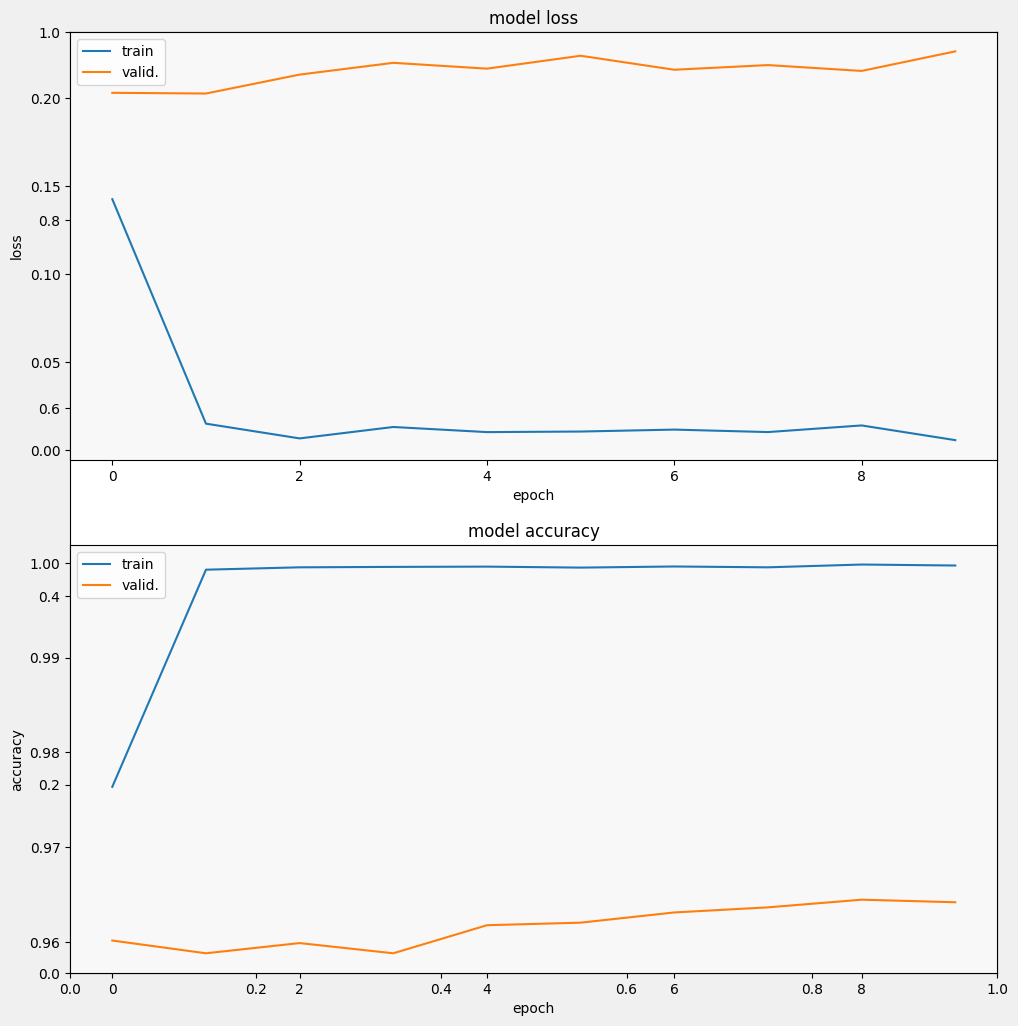

In [16]:
display_training_curves(
    history.history['loss'],
    history.history['val_loss'],
    'loss',
    211,
)
display_training_curves(
    history.history['sparse_categorical_accuracy'],
    history.history['val_sparse_categorical_accuracy'],
    'accuracy',
    212,
)

<a name="6"></a>
# 6. Evaluate Predictions #

In [17]:
def display_confusion_matrix(cmat, score, precision, recall):
    plt.figure(figsize=(15,15))
    ax = plt.gca()
    ax.matshow(cmat, cmap='Reds')
    ax.set_xticks(range(len(CLASSES)))
    ax.set_xticklabels(CLASSES, fontdict={'fontsize': 7})
    plt.setp(ax.get_xticklabels(), rotation=45, ha="left", rotation_mode="anchor")
    ax.set_yticks(range(len(CLASSES)))
    ax.set_yticklabels(CLASSES, fontdict={'fontsize': 7})
    plt.setp(ax.get_yticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    titlestring = ""
    if score is not None:
        titlestring += 'f1 = {:.3f} '.format(score)
    if precision is not None:
        titlestring += '\nprecision = {:.3f} '.format(precision)
    if recall is not None:
        titlestring += '\nrecall = {:.3f} '.format(recall)
    if len(titlestring) > 0:
        ax.text(101, 1, titlestring, fontdict={'fontsize': 18, 'horizontalalignment':'right', 'verticalalignment':'top', 'color':'#804040'})
    plt.show()
    
def display_training_curves(training, validation, title, subplot):
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    #ax.set_ylim(0.28,1.05)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

## Confusion Matrix ##

In [18]:
cmdataset = get_validation_dataset(ordered=True)
images_ds = cmdataset.map(lambda image, label: image)
labels_ds = cmdataset.map(lambda image, label: label).unbatch()

cm_correct_labels = next(iter(labels_ds.batch(NUM_VALIDATION_IMAGES))).numpy()
cm_probabilities = out.predict(images_ds)
cm_predictions = np.argmax(cm_probabilities, axis=-1)

labels = range(len(CLASSES))
cmat = confusion_matrix(
    cm_correct_labels,
    cm_predictions,
    labels=labels,
)
cmat = (cmat.T / cmat.sum(axis=1)).T # normalize

2023-11-11 22:58:13.648723: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


29/29 [==============================] - 82s 629ms/step


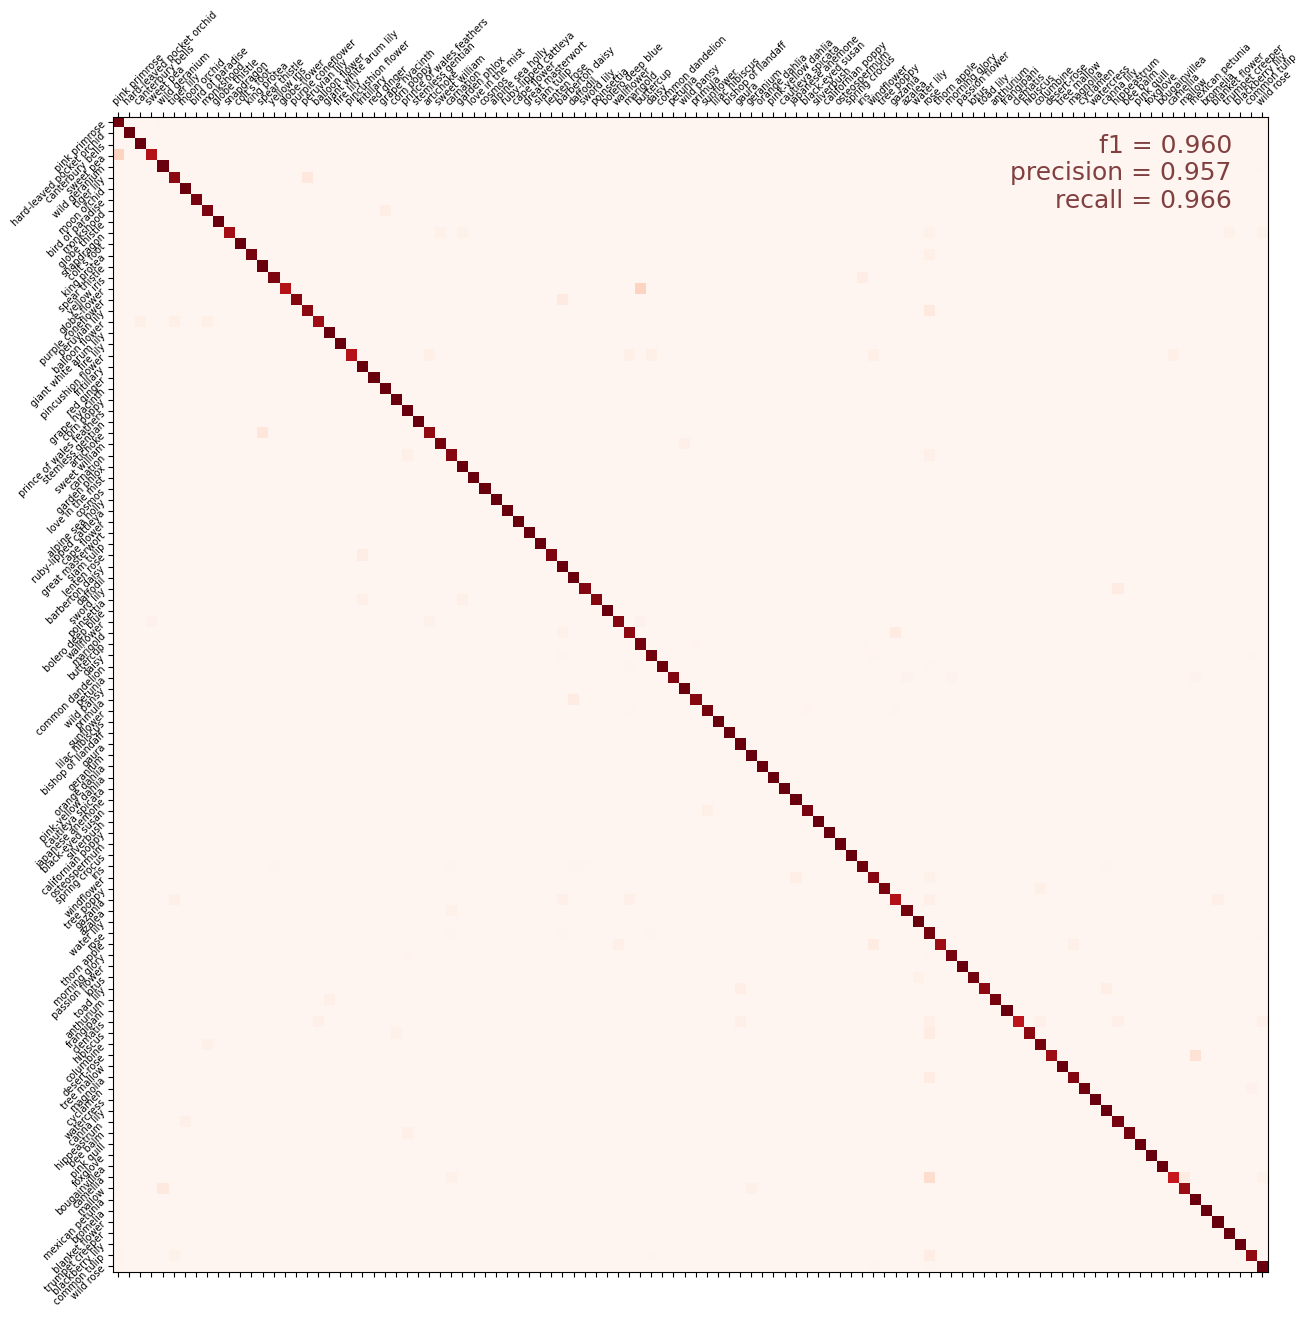

In [19]:
score = f1_score(cm_correct_labels, cm_predictions,labels=labels, average='macro')
precision = precision_score(cm_correct_labels, cm_predictions, labels=labels, average='macro')
recall = recall_score(cm_correct_labels, cm_predictions, labels=labels, average='macro')

display_confusion_matrix(cmat, score, precision, recall)

<a name="7"></a>
# 7. Make Test Predictions #

In [20]:
test_ds = get_test_dataset(ordered=True)

print('Computing predictions...')
test_images_ds = test_ds.map(lambda image, idnum: image)
probabilities = out.predict(test_images_ds)
predictions = np.argmax(probabilities, axis=-1)
print(predictions)

Computing predictions...
58/58 [==============================] - 78s 1s/step
[  8  83 103 ...  49  45  95]


In [21]:
# Get image ids from test set and convert to unicode
test_ids_ds = test_ds.map(lambda image, idnum: idnum).unbatch()
test_ids = next(iter(test_ids_ds.batch(NUM_TEST_IMAGES))).numpy().astype('U')

print('Generating submission.csv file...')

# Write the submission file
np.savetxt(
    'submission.csv',
    np.rec.fromarrays([test_ids, predictions]),
    fmt=['%s', '%d'],
    delimiter=',',
    header='id,label',
    comments='',
)

# Look at the first few predictions
!head submission.csv

Generating submission.csv file...
id,label
0b9afbdf2,8
c37a6f3e9,83
00e4f514e,103
1c4736dea,28
252d840db,67
dfc9c6a23,103
53cfc6586,29
541c4d41e,73
59d1b6146,70
